In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
import plotly.express as px
import scipy
import seaborn as sns
sns.set(style='whitegrid') 

fig_DIR = "../figs/team_leaders/"

In [2]:
from plotnine import ggplot,aes,ggsave,themes,theme
from plotnine import geom_point, geom_line,geom_smooth,geom_hline,facet_wrap,geom_boxplot,geom_violin,geom_density
from plotnine import labs,element_rect,element_blank,element_text
from plotnine import scale_color_manual,scale_y_continuous, ylim, scale_x_date,scale_color_identity
theme_sra = themes.theme_538(base_size=9, base_family="Tahoma")
theme_sra += theme(
                    # plot_background = element_rect(fill = 'ghostwhite', color = "ghostwhite"),
                    plot_title = element_text(face = 'bold',size=16),
                    strip_text = element_text(face = 'bold',size=10),
                    plot_caption = element_text(size=10),
                    plot_subtitle = element_text(size=12),
                    axis_text_x = element_text(size=8),
                    axis_text_y = element_text(size=8),
                    axis_title_x = element_text(size=12),
                    axis_title_y = element_text(size=12)
                ) 

In [3]:
from nba_api.stats.endpoints import leaguegamelog

In [50]:
def get_rolling_ratings(season = 2023, min_games = 5):
    df1 = pd.read_csv(f"./boxscores/NBA_BoxScores_Adv_{season}.csv")
    cols = ["gameId","teamId","offensiveRating","defensiveRating","netRating","possessions"]
    df1 = df1[cols]
    df1["Win"]  = df1["netRating"] >0
    df1["Loss"]  = df1["netRating"] <0
    # stats = leaguegamelog.LeagueGameLog(player_or_team_abbreviation="T",season=season,season_type_all_star="Regular Season")
    # df2 = stats.get_data_frames()[0]
    df2 = pd.read_csv(f"./boxscores/NBA_BoxScores_Standard_{season}.csv")

    df2 = df2.rename(columns={"GAME_ID":"gameId","TEAM_ID":"teamId","TEAM_ABBREVIATION":"teamTricode","GAME_DATE":"gameDate","TEAM_NAME":"teamName"})
    cols2 = ["gameId","teamId","teamTricode","gameDate"]
    df2 = df2[cols2]
    df2["gameId"] = df2["gameId"].astype(int)
    df3 = pd.merge(df2,df1,on=["gameId","teamId"])
    df4 = df3.sort_values(by=["teamTricode","gameDate"]).reset_index(drop=True)
    df6 = df3.sort_values(by=["gameDate"]).reset_index(drop=True)
    teams = df6["teamTricode"].unique()

    dfa = []
    dfa2 = []
    for team in teams:
        df5 = df4[df4["teamTricode"]==team].reset_index(drop=True)
        df5["oPts"] = df5["offensiveRating"]*df5["possessions"]
        df5["dPts"] = df5["defensiveRating"]*df5["possessions"]
        df5["roPts"]=df5["oPts"].cumsum()
        df5["rdPts"]=df5["dPts"].cumsum()
        df5["rPoss"]=df5["possessions"].cumsum()
        df5["Wins"]=df5["Win"].cumsum()
        df5["Losses"]=df5["Loss"].cumsum()
        df5["Games_Played"] = df5["Wins"] + df5["Losses"]
        df5["Win_Frac"] = df5["Wins"]/df5["Games_Played"]
        df5["rORtg"]=df5["roPts"] / df5["rPoss"]
        df5["rDRtg"]=df5["rdPts"] / df5["rPoss"]
        df5["rNRtg"] = df5["rORtg"] - df5["rDRtg"]
        df5["rORtg"] = df5["rORtg"].round(2)
        df5["rDRtg"] = df5["rDRtg"].round(2)
        df5["rNRtg"] = df5["rNRtg"].round(2)
        df5["Win_Frac"] = df5["Win_Frac"].round(4)
        df5["Win_Percent"]  = 100*df5["Win_Frac"]
        df7 = df5.tail(1)
        df5 = df5[(df5["Win_Frac"]>0) & (df5["Win_Frac"]<1) & (df5["Games_Played"]>min_games) ].reset_index(drop=True)
        dfa.append(df5)
        dfa2.append(df7)
    data = pd.concat(dfa)
    dataf = pd.concat(dfa2)
    data["Team"] = data["teamTricode"]
    dataf["Team"] = dataf["teamTricode"]
    data = data.rename(columns={"gameDate":"Date"})
    dataf = dataf.rename(columns={"gameDate":"Date"})

    return data,dataf

In [95]:
dfa1, dfa2 = [], []
dfa3, dfa4 = [], []
for season in range(2010,2023):
    df1,df2 = get_rolling_ratings(season,min_games = 5) 
    df3,_ = get_rolling_ratings(season,min_games = 10) 
    df4,_ = get_rolling_ratings(season,min_games = 15) 
    dfa1.append(df1)
    dfa2.append(df2)
    dfa3.append(df3)
    dfa4.append(df4)
data = pd.concat(dfa1)
dataf = pd.concat(dfa2)
data2 = pd.concat(dfa3)
data3 = pd.concat(dfa4)

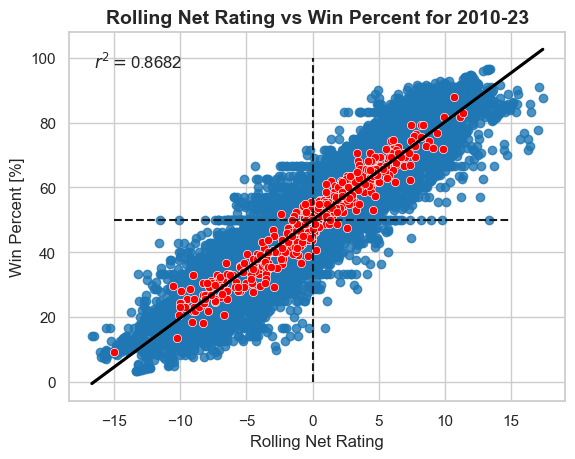

In [114]:
var1 = "rNRtg"
var2 = "Win_Percent"
var3 = "Win_Frac"
slope, intercept, r, p, sterr = scipy.stats.linregress(x=data[var1], y=data[var3])
mfit = slope
cfit = intercept
slope0, intercept0, r0, p0, sterr0 = scipy.stats.linregress(x=dataf[var1], y=dataf[var3])
R2 = r**2
fig, ax = plt.subplots(1,1)
ax.vlines(x=0,ymin=0,ymax=100,color="k",linestyles="--")
ax.hlines(y=50,xmin=-15,xmax=15,color="k",linestyles="--")
sns.regplot(x = var1, y = var2, data = data,color ="black",scatter_kws = {"color":"tab:blue"} ,ax=ax)
sns.scatterplot(x = var1, y = var2, data = dataf, color="red", ax = ax)
ax.text(0.05,0.90,r"$r^2=$"+f"{round(R2,4)}",transform = ax.transAxes)

ax.set_title("Rolling Net Rating vs Win Percent for 2010-23",fontsize=14,fontweight="bold")
ax.set_xlabel("Rolling Net Rating")
ax.set_ylabel("Win Percent [%]")
plt.savefig("../figs/team_leaders/NET_WinLoss_R2.png")
plt.show()

In [97]:

data["Win_Frac_Pred"] =  cfit + mfit * data["rNRtg"]
data["Wins_Pred"] = data["Win_Frac_Pred"] * data["Games_Played"]
data["Wins_Pred"] = data["Wins_Pred"].round().astype(int)
data["Losses_Pred"] = data["Games_Played"] - data["Wins_Pred"]

In [98]:
dataf["Win_Frac_Pred"] =  cfit + mfit * dataf["rNRtg"]
dataf["Wins_Pred"] = dataf["Win_Frac_Pred"] * dataf["Games_Played"]
dataf["Wins_Pred"] = dataf["Wins_Pred"].round().astype(int)
dataf["Losses_Pred"] = dataf["Games_Played"] - dataf["Wins_Pred"]

In [103]:
# dataf[["Games_Played","rNRtg","Wins","Wins_Pred","Losses","Losses_Pred"]]

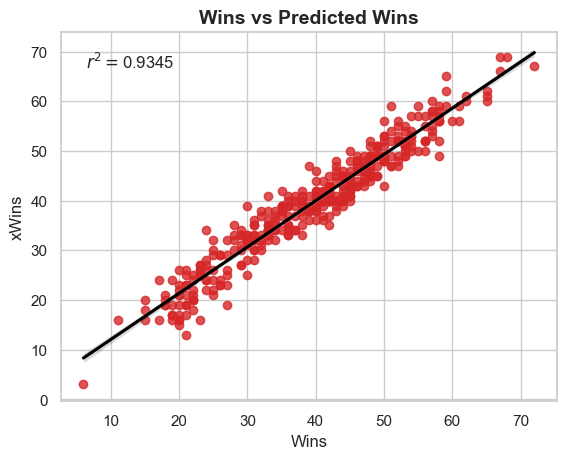

In [104]:
fig, ax = plt.subplots(1,1)
var1 = "Wins"
var2 = "Wins_Pred"
slope, intercept, r, p, sterr = scipy.stats.linregress(x=dataf[var1], y=dataf[var2])
R2 = r**2
sns.regplot(x = var1, y = var2, data = dataf,color ="black",scatter_kws = {"color":"tab:red"} ,ax=ax)
ax.text(0.05,0.90,r"$r^2=$"+f"{round(R2,4)}",transform = ax.transAxes)
ax.set_title("Wins vs Predicted Wins",fontsize=14,fontweight="bold")
ax.set_xlabel("Wins")
ax.set_ylabel("xWins")
plt.savefig("../figs/team_leaders/simple_win_model.png")
plt.show()

In [115]:
season = "2023"
dfc,dfcf = get_rolling_ratings(season,min_games = 5) 
dfcf["Win_Frac_Pred"] =  cfit + mfit * dfcf["rNRtg"]
dfcf["Wins_Pred"] = dfcf["Win_Frac_Pred"] * dfcf["Games_Played"]
dfcf["Wins_Pred"] = dfcf["Wins_Pred"].round().astype(int)
dfcf["Losses_Pred"] = dfcf["Games_Played"] - dfcf["Wins_Pred"]

In [113]:
# dfcf[["Games_Played","rNRtg","Wins","Wins_Pred","Losses","Losses_Pred"]]

In [119]:
import seaborn.objects as snso

In [127]:
dfcf = dfcf.reset_index(drop=True)

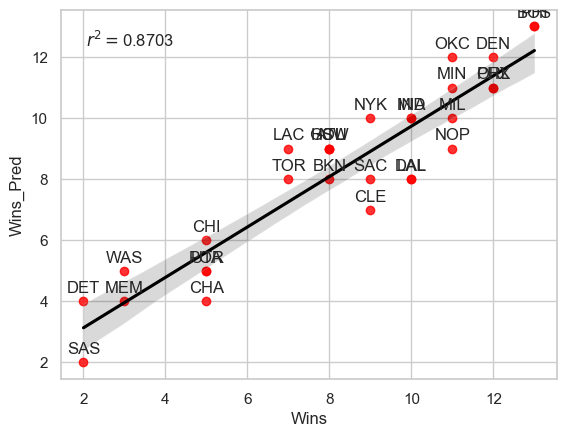

In [150]:
fig, ax = plt.subplots(1,1)
var1 = "Wins"
var2 = "Wins_Pred"
slope, intercept, r, p, sterr = scipy.stats.linregress(x=dfcf[var1], y=dfcf[var2])
R2 = r**2
sns.regplot(x = var1, y = var2, data = dfcf,color ="black",scatter_kws = {"color":"red"} ,ax=ax)
ax.text(0.05,0.90,r"$r^2=$"+f"{round(R2,4)}",transform = ax.transAxes)
p = snso.Plot(data = dfcf,x=var1,y=var2,text="Team").add(snso.Text(valign="bottom"))
p.on(ax).show();
ax.set_title("Wins vs Predicted Wins 2023-24",fontsize=14,fontweight="bold")
ax.set_xlabel("Wins")
ax.set_ylabel("xWins")
ax.set_ylim([1,14])
fig.savefig("../figs/team_leaders/simple_win_model_2023.png")
plt.show()